## Import the necessary libraries

In [ ]:
import sys

from scipy.optimize import curve_fit

sys.path.append("../../src")

from relaxometrynmr.core import T1Functions

import numpy as np

import matplotlib.pyplot as plt

## specify path to the data file and ensure that "\\\\" is appended to the end of the path

 - create an instance t1 of T1Functions
  
Note: This data is a T1<sub>ρ</sub> data

In [20]:
filepath = r"..\..\data\T1_rho_data\79\\"

t1 = T1Functions(filepath)

## Read and convert Bruker NMR data to NMRPipe and CSDM formats: read_and_convert_bruker_data.

The function automatically detects and loads the variable delay list (vdlist, vplist, vclist) used in the experiment. In this case, the vplist is loaded, but vdlist terminology will be used.

It returns a tuple containing three elements: a list of 1D NMR (spectra), the variable delay list (vd_list), and the complete dataset in CSDM format (csdm_ds)

In [21]:
spectra, vd_list, csdm_ds = t1.read_and_convert_bruker_data(filepath)

## Process the returned 1D NMR spectra
 - apply the Gaussian apodisation (fwhm)
 - zero-filling for increased digital resolution (zero_fill_factor)
 - 0th order phase correction (ph0)
 - 1st order phase correction (ph1) -- this phase correction is a bit nuanced and so far, a value of 0 - 0.6 ° has worked quite well: see the "Understanding Phasing" example under User Guide
 - In applying the 1st order correction, you would have to experiment with the mentioned values to obtain a pure absorption line-shape signal

In [22]:
exp_spectra = []
for i, spectrum in enumerate(spectra):
    if i == 0:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=-25, ph1=0.005)
        exp_spectra.append(exp_spectrum)
    elif i == 1:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=-20, ph1=0.005)
        exp_spectra.append(exp_spectrum)
    elif i == 2:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=5, ph1=0.006)
        exp_spectra.append(exp_spectrum)
    elif i == 3:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=5, ph1=0.004)
        exp_spectra.append(exp_spectrum)
    elif i == 4:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=-5, ph1=0.005)
        exp_spectra.append(exp_spectrum)
    elif i ==5:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=-5, ph1=0.006)
        exp_spectra.append(exp_spectrum)
    else:
        exp_spectrum = t1.process_spectrum(spectrum, fwhm="1200 Hz", zero_fill_factor=10, ph0=-10, ph1=0.005)
        exp_spectra.append(exp_spectrum)

## Find the area under the peak of interest using the ``integrate_spectrum_region()`` function
The integration function employed here integrate each spectrum using trapezoid and simpson function, respectively.
ppm_start and ppm_end need to be defined as the starting and ending ppm region needed to be integrated. 
The integrated area of each spectrum is appended to trapz_ints and simps_ints, respectively.
x_ and y_regions are regions of integration in the spectra -- needed for visuals.


 - There is no difference between trapz and simps, so you would have to use either of the two in a later stage

In [23]:
trapz_ints = []
simps_ints = []
x_regions = []
y_regions = []
int_uncs = []
for i, exp_spectrum in enumerate(exp_spectra):
    trapz_int, simps_int, x_region, y_region, int_unc = t1.integrate_spectrum_region(exp_spectrum, ppm_start=-200, ppm_end=200)
    trapz_ints.append(trapz_int)
    simps_ints.append(simps_int)
    x_regions.append(x_region)
    y_regions.append(y_region)
    int_uncs.append(int_unc)

## plot_spectra_and_zoom() function
 - creates plots of NMR spectra with both full view and zoomed regions (max and min x zoom)
 - highlights the integrated x_ and y_regions on the zoomed plot
 - returns maximum intensities from each spectrum (abs_ints): relevant for relaxometry just like integrated areas contained in trapz_ints and simps_ints

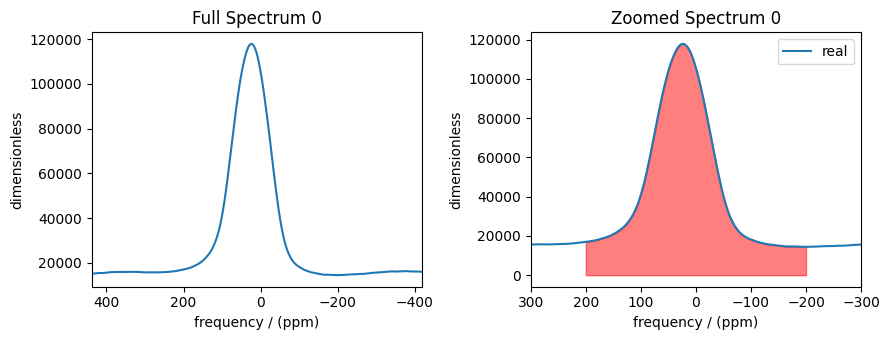

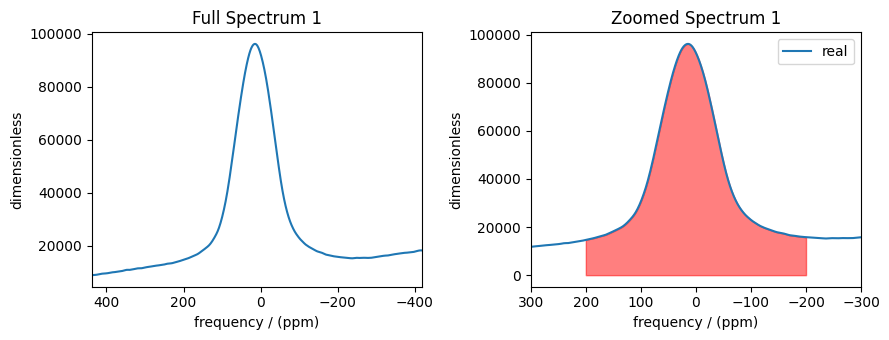

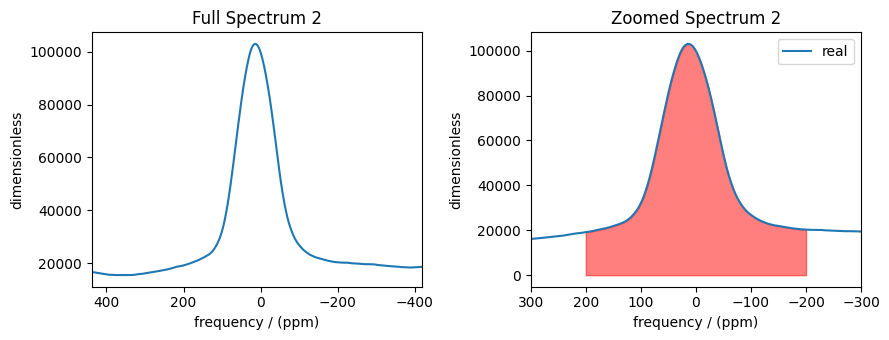

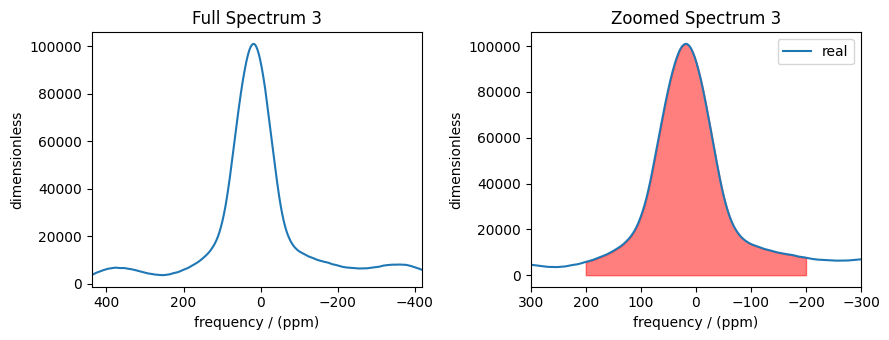

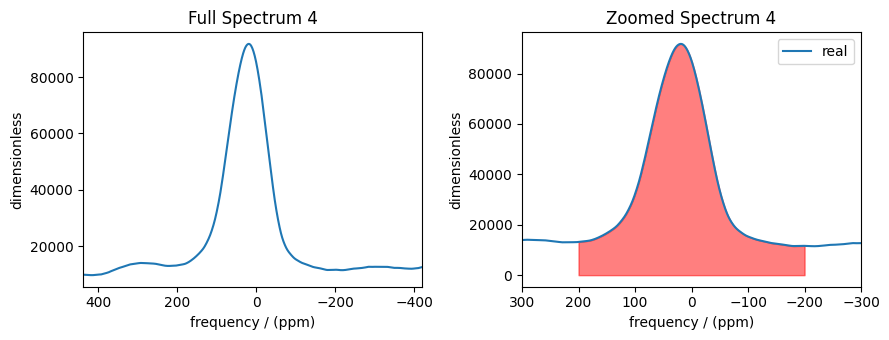

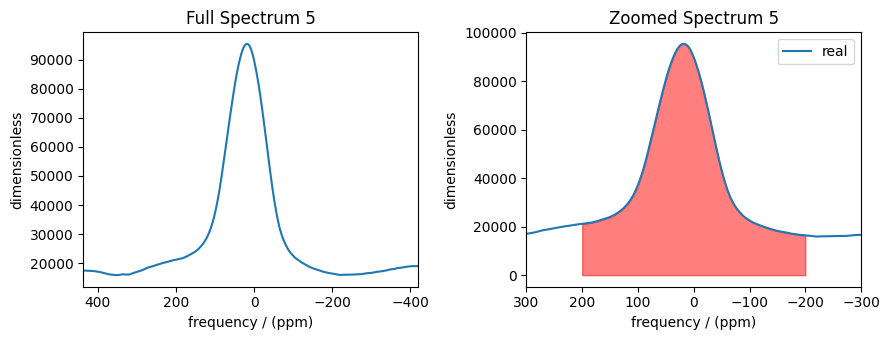

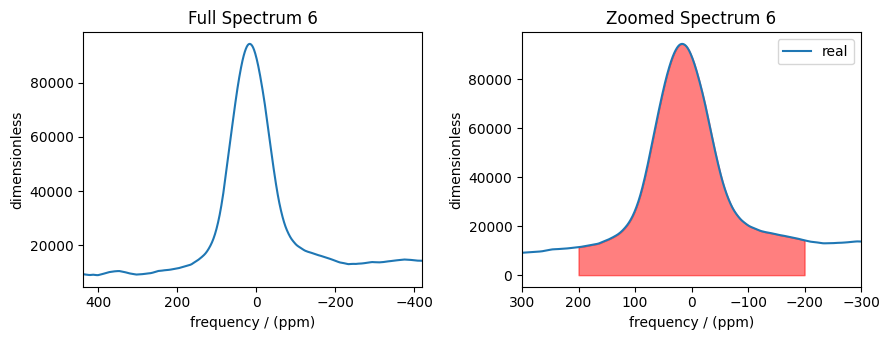

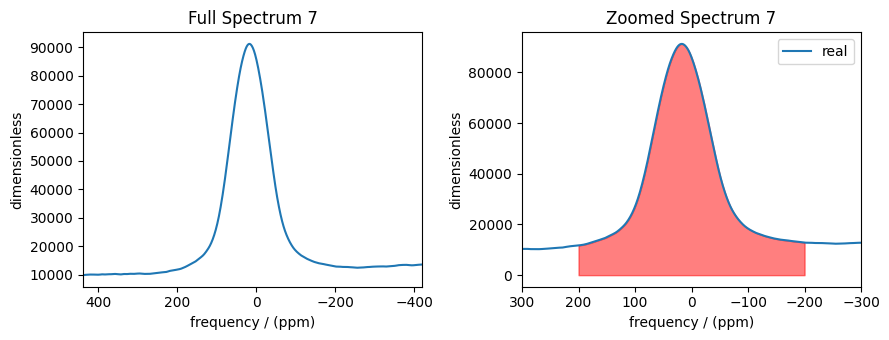

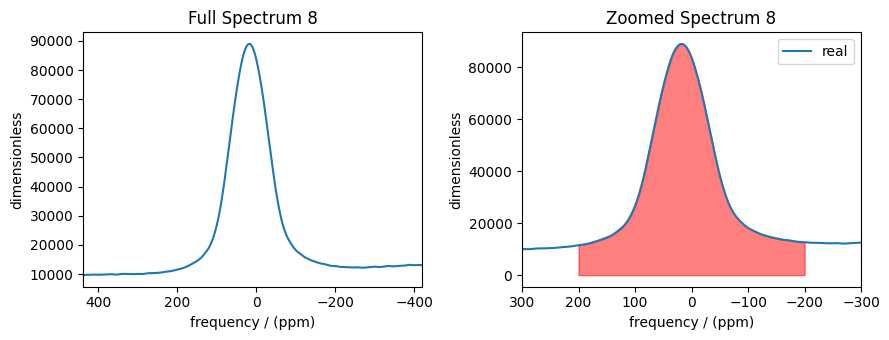

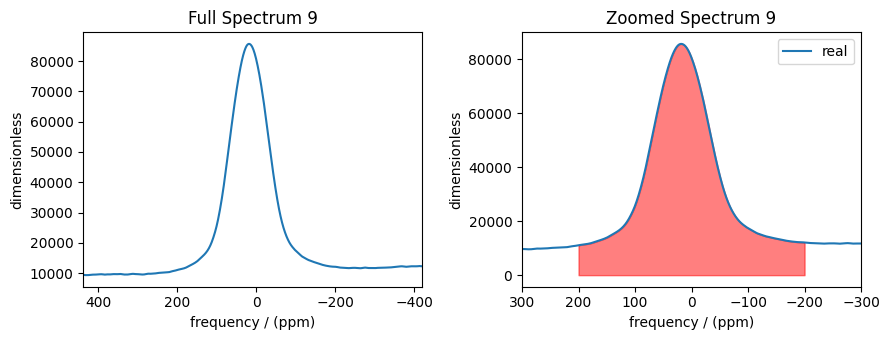

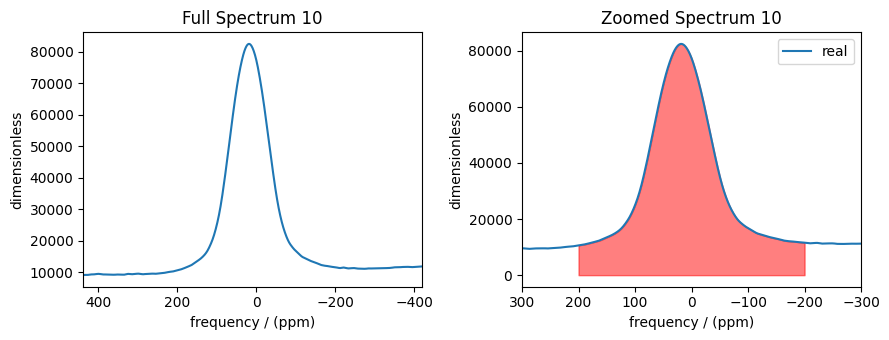

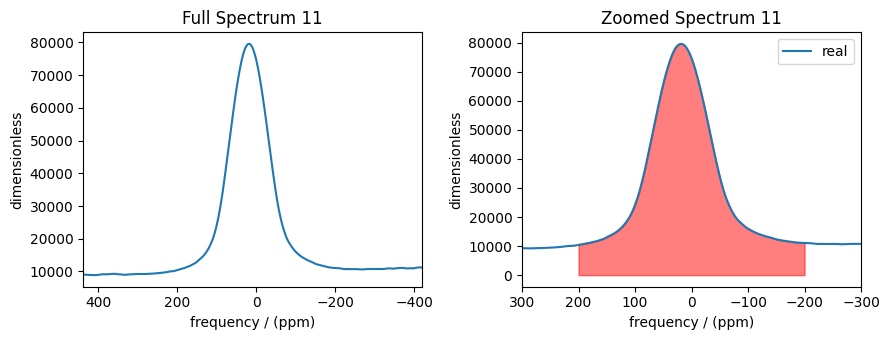

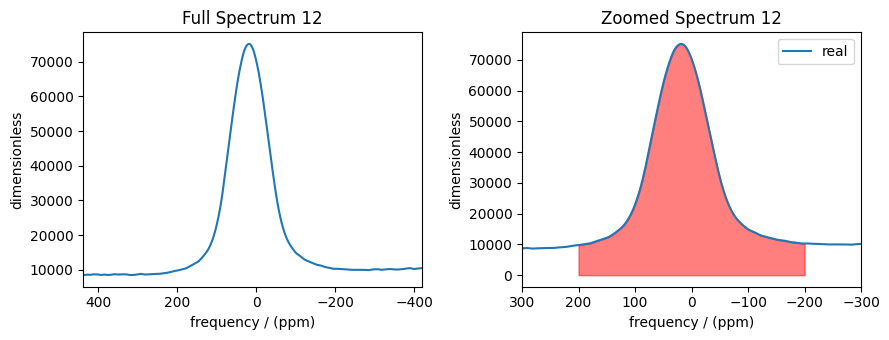

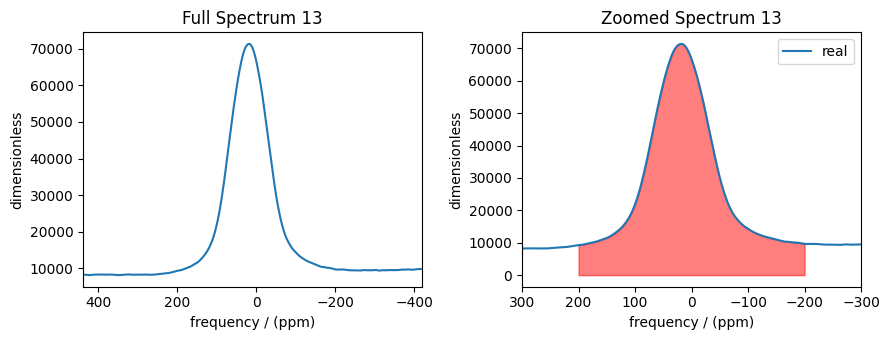

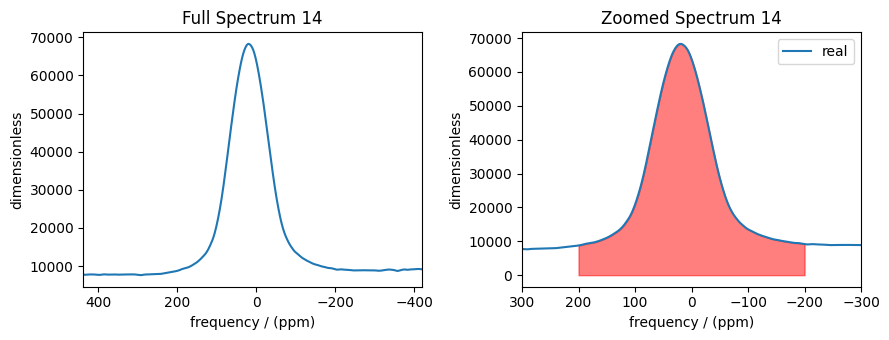

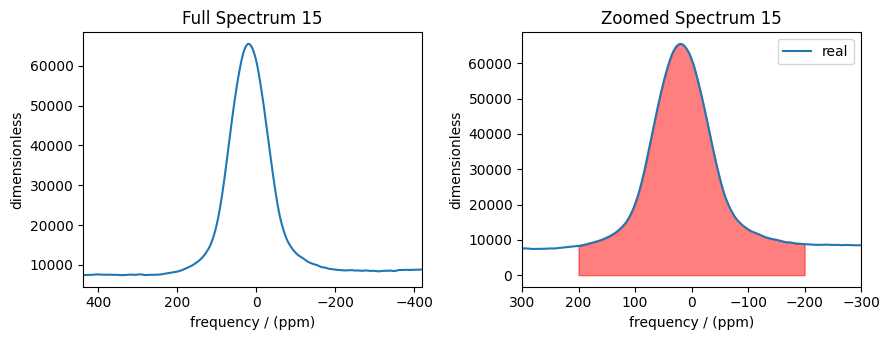

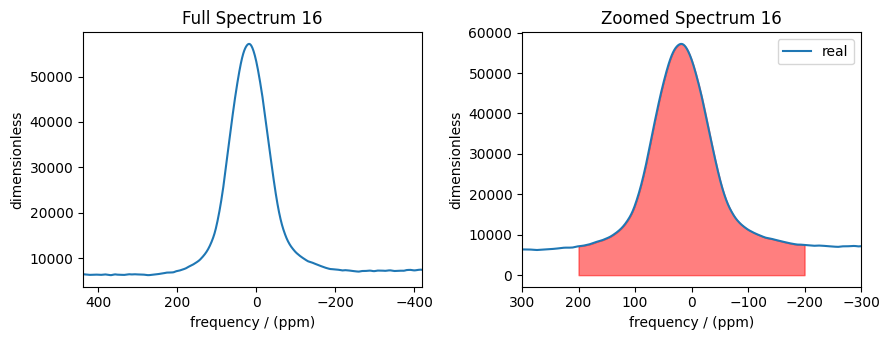

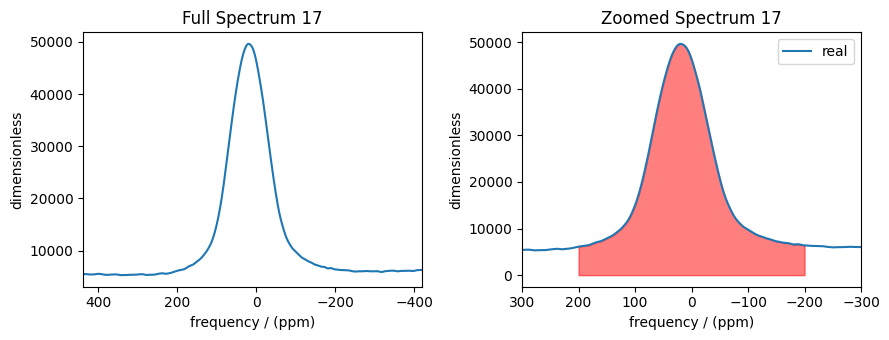

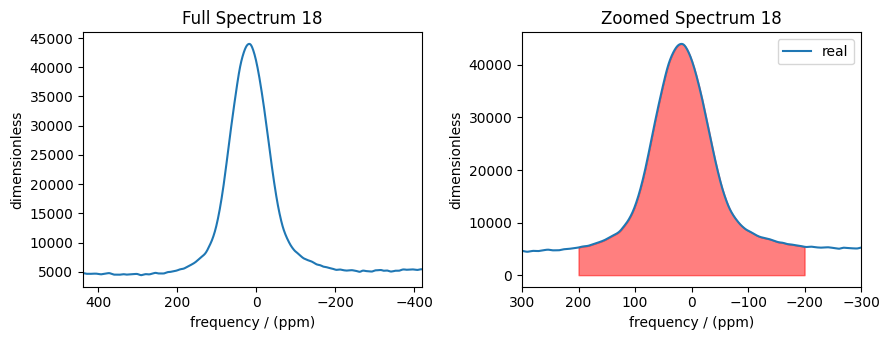

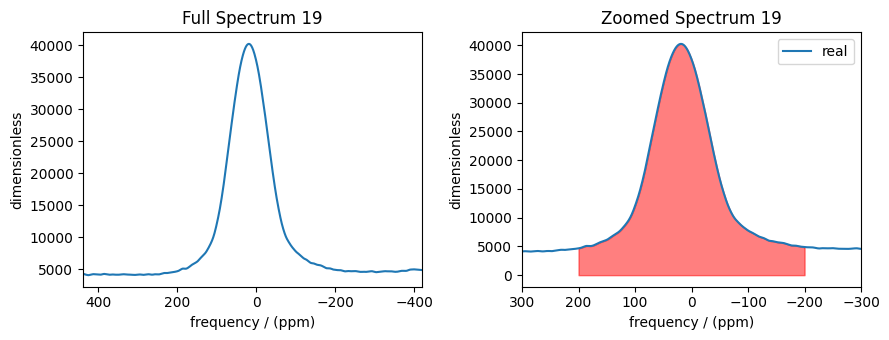

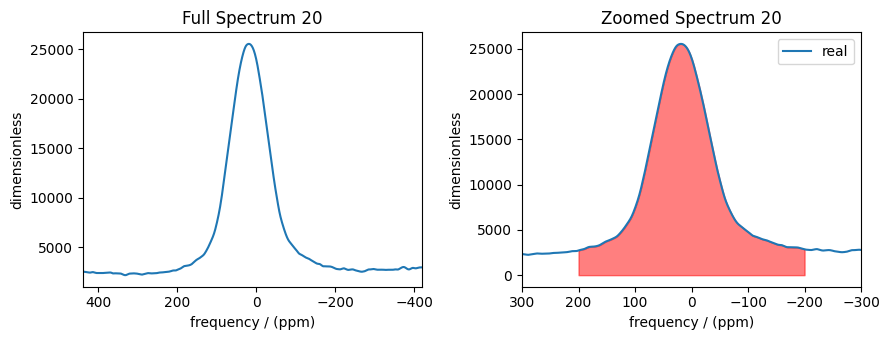

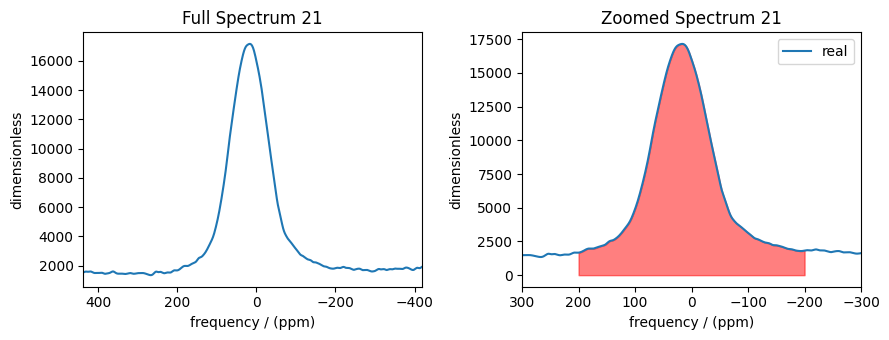

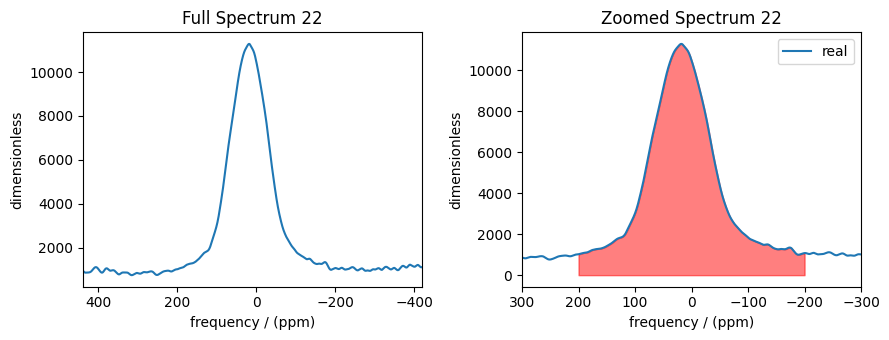

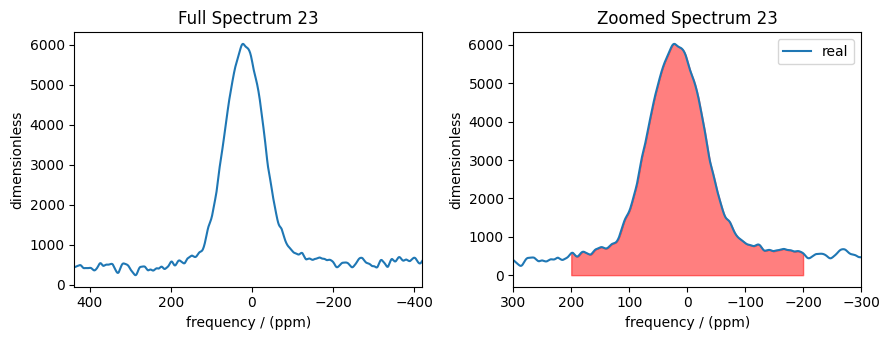

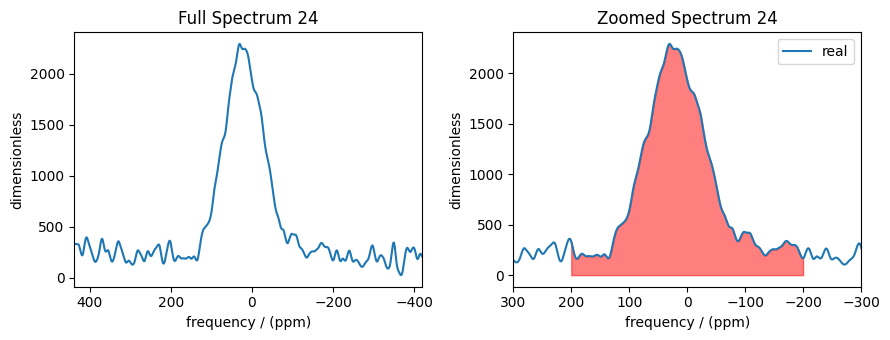

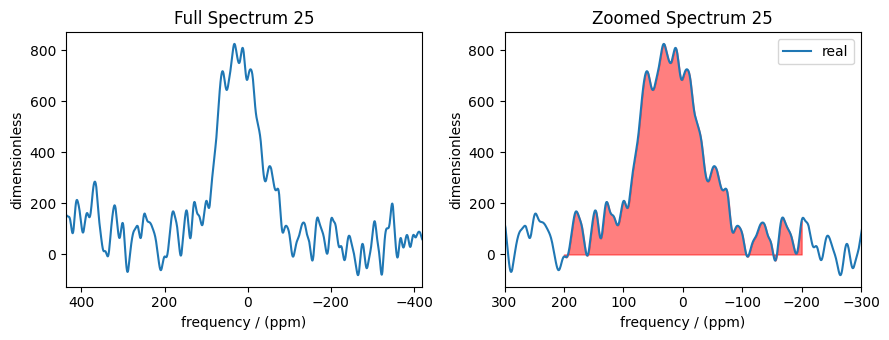

In [24]:
max_x_zoom = 300

min_x_zoom = -300

abs_ints = t1.plot_spectra_and_zoomed_regions(exp_spectra, x_regions, y_regions, max_x_zoom, min_x_zoom)

## Convert vd list to numpy array and ensure that the list and extracted intensities and areas are of the same length 

In [25]:
#vd_list imported from the file_path and converted into a numpy array

vd_list = np.array(vd_list)

#slicing the vd_list if some data points are shitty
vd_list = vd_list[:len(abs_ints)]

#slicing the intensities if some data points are shitty

simps_ints = simps_ints[:len(vd_list)]

abs_ints = abs_ints[:len(vd_list)]

## Viusalise the list and the extracted intensities and areas
 - the extracted areas from either trapz or simps integration and extracted max intensities of each spectrum are plotted against corresponding time in vd_list

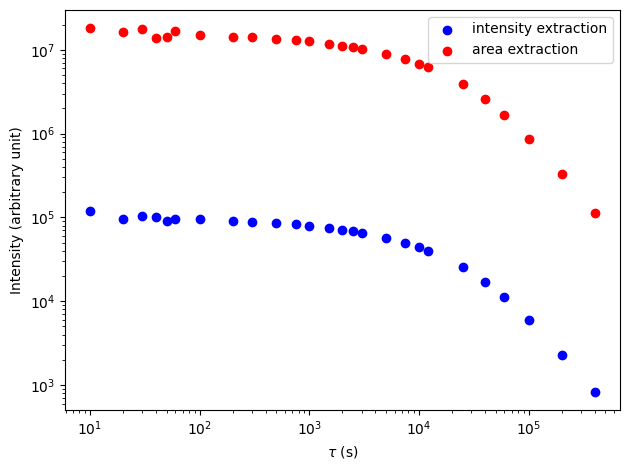

In [26]:
fig, ax = plt.subplots()

ax.scatter(vd_list, abs_ints, color='blue', label='intensity extraction')


ax.scatter(vd_list, simps_ints, color='red', label='area extraction')

ax.semilogy()

ax.semilogx()

ax.legend(loc='best', frameon=True)

ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Intensity (arbitrary unit)')



plt.tight_layout()

plt.show()

## Let us fit one of the data with a tri-expdec function: here we are using the area, the intesities can also be utilised

This choice of fitting is because the system has multiple relaxation times and so far 3 distinct relaxation behaviours have been identified -- so the choice of using tri-expdec

T1_simps_area: 2632.574307826575 ± 1061.1625378446793
T2_simps_area: 32453.487188215673 ± 7365.197180027149
T3_simps_area: 22.480654605773015 ± 13.143182370529482
A_simps_area: 9696043.108843263 ± 11069905220459.34
C_simps_area: 0.591214385161623 ± 675375.4260679492
D_simps_area: 0.9405822799092332 ± 1074465.1370789001
E_simps_area: 0.5042540265454778 ± 576029.2275655189
2.036050691616334


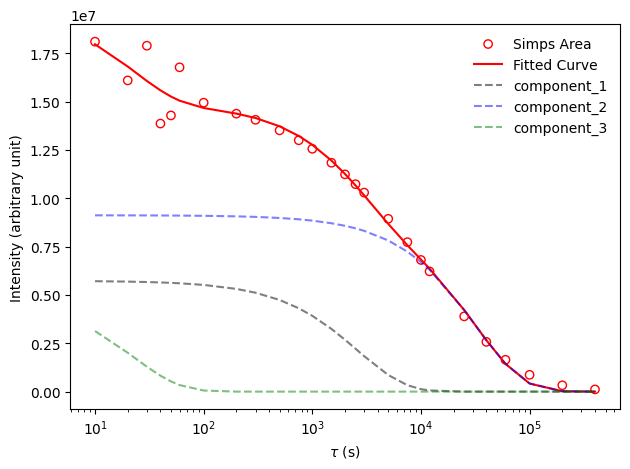

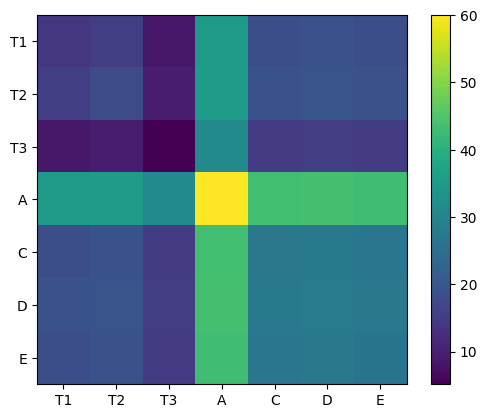

In [27]:
#T1rho fitting of the data
fig, ax = plt.subplots()

output_lines = []

# Define a list of tuples for the two sets of intensities

intensity_sets = [
    (simps_ints, 'Simps Area', 'Guess Curve', 'Fitted Curve', 'r'),
    (abs_ints, 'Absolute Intensities', 'Guess Abs Int Curve', 'Fitted Curve Absolute Intensity', 'b')
]


# Initial guess parameters

T1_guess = 3347

T2_guess = 34555

T3_guess = 52



for i, (ints, label, guess_label, fitted_label, color) in enumerate(intensity_sets):
    if i ==0:
        # A_guess = np.max(ints)
        A_guess = 1e7
        
        B_guess = np.min(ints)
        
        C_guess = 0.48
        
        D_guess = 0.2
        
        E_guess = 0.53
        
    
        ax.scatter(vd_list, ints, color=color, marker='o', facecolors='none', label=label)
    
        # Guess curve
        guess_integrated_int = t1.tri_expdec(vd_list, T1_guess, T2_guess, T3_guess, A_guess, C_guess, D_guess, E_guess)
        # guess_integrated_int = t1.expdec(vd_list, T1_guess, T2_guess, T3_guess, A_guess, B_guess)
        
        # ax.plot(vd_list, guess_integrated_int, color='brown', linestyle='--', label=guess_label, alpha=0.9)
    
    # Fit the data
        popt, pcov = curve_fit(t1.tri_expdec, vd_list, ints, p0=[T1_guess, T2_guess, T3_guess, A_guess, C_guess, D_guess, E_guess])
    
    # Save the fitted params and uncertainties
        T1_fitted, T2_fitted, T3_fitted, A_fitted, C_fitted, D_fitted, E_fitted = popt
        T1_unc, T2_unc, T3_unc, A_unc, C_unc, D_unc, E_unc = np.sqrt(np.diag(pcov))
        
        #define T1 and T2
        component_1 = A_fitted *  (C_fitted)*np.exp(-vd_list/T1_fitted)
        
        component_2 = A_fitted * (D_fitted)*np.exp(-vd_list/T2_fitted)
        
        component_3 = A_fitted * (E_fitted)*np.exp(-vd_list/T3_fitted) 
        
        overall_component = component_1 + component_2 + component_3
    
    # Extract the fitted curve
        fitted_curve = t1.tri_expdec(vd_list,T1_fitted, T2_fitted, T3_fitted, A_fitted, C_fitted, D_fitted, E_fitted)
        ax.plot(vd_list, fitted_curve, linestyle='-', color=color, label=fitted_label)
        ax.plot(vd_list, component_1, linestyle='--', color='black', alpha=0.5, label='component_1')
        ax.plot(vd_list, component_2, linestyle='--', color='blue', alpha=0.5, label='component_2')
        ax.plot(vd_list, component_3, linestyle='--', color='green', alpha=0.5, label='component_3')
       
    
    # print the fitted parameters and uncertainties
        print(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}')
        print(f'T2_{label.lower().replace(" ", "_")}: {T2_fitted} ± {T2_unc}')
        print(f'T3_{label.lower().replace(" ", "_")}: {T3_fitted} ± {T3_unc}')
        print(f'A_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}')
        print(f'C_{label.lower().replace(" ", "_")}: {C_fitted} ± {C_unc}')
        print(f'D_{label.lower().replace(" ", "_")}: {D_fitted} ± {D_unc}')
        print(f'E_{label.lower().replace(" ", "_")}: {E_fitted} ± {E_unc}')
        print(E_fitted+C_fitted+D_fitted)
    
    
    # #Format the string and append fitted parameters
        
        output_lines.append(f'M0_{label.lower().replace(" ", "_")}: {A_fitted} ± {A_unc}\n')
        output_lines.append(f'T1_{label.lower().replace(" ", "_")}: {T1_fitted} ± {T1_unc}\n')
        output_lines.append(f'T2_{label.lower().replace(" ", "_")}: {T2_fitted} ± {T2_unc}\n')
        output_lines.append(f'T3_{label.lower().replace(" ", "_")}: {T3_fitted} ± {T3_unc}\n')
        output_lines.append(f'C_{label.lower().replace(" ", "_")}: {C_fitted} ± {C_unc}\n')
        output_lines.append(f'D_{label.lower().replace(" ", "_")}: {D_fitted} ± {D_unc}\n')
        output_lines.append(f'E_{label.lower().replace(" ", "_")}: {E_fitted} ± {E_unc}\n')
        #save the fitted params and uncertainties in a text file
        with open(filepath+'multi_exp_fitted_params.txt', 'w') as f:
            f.writelines(output_lines)


ax.semilogx()
ax.legend(loc='best', frameon=False)
ax.set_xlabel(r'$\tau$ (s)')
ax.set_ylabel('Intensity (arbitrary unit)')


#plot the covariance matrix in another figure and label the axes with the fitted parameters

plt.savefig(filepath+'multi_exp_T1_fitting.svg', bbox_inches='tight', transparent=True)
plt.tight_layout()
fig, ax = plt.subplots()
im = ax.imshow(np.log(np.abs(pcov)))
ax.set_xticks(np.arange(len(popt)))
ax.set_yticks(np.arange(len(popt)))
ax.set_xticklabels(['T1', 'T2', 'T3', 'A', 'C', 'D', 'E'])
ax.set_yticklabels(['T1', 'T2', 'T3', 'A', 'C', 'D', 'E'])
plt.colorbar(im)
plt.show()
plt.clf()
plt.close()